In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN

#### data

In [3]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

In [4]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

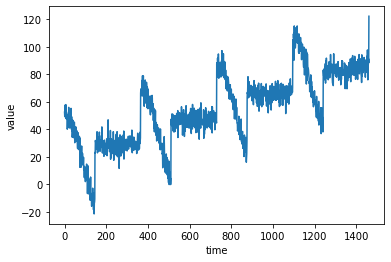

In [5]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [6]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [7]:
window=20
batch=32
shuffle_buffer=1000

In [8]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [9]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

In [1]:
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

#### model

In [13]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


#### tune learning rate

In [2]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

(1e-08, 0.001, 0.0, 300.0)

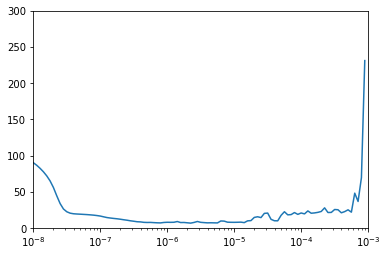

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

#### model training

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

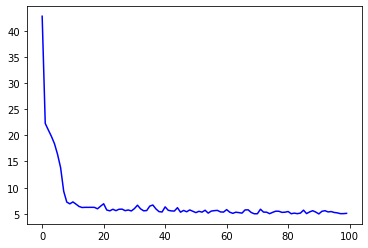

In [18]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediciton

In [ ]:
forecast = []
series_f=series[split_time-window:]
for time in range(len(series_f)-window):
  forecast.append(model.predict(series_f[time:time+window][np.newaxis]))

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_val.shape}')

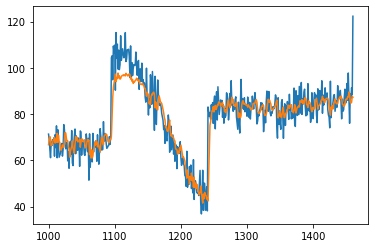

In [20]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [21]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

49.18853
5.1733055


---

# LSTM

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

#### data

In [3]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

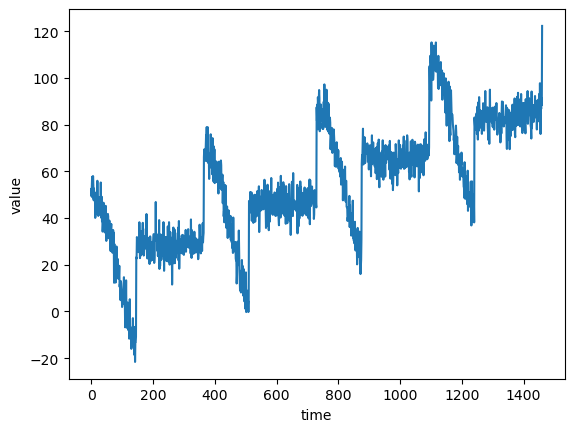

In [4]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [5]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [6]:
window=20
batch=32
shuffle_buffer=1000

In [7]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [8]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

In [ ]:
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

#### model

In [12]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

#### tuning learning rate

In [ ]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

(1e-08, 0.001, 0.0, 30.0)

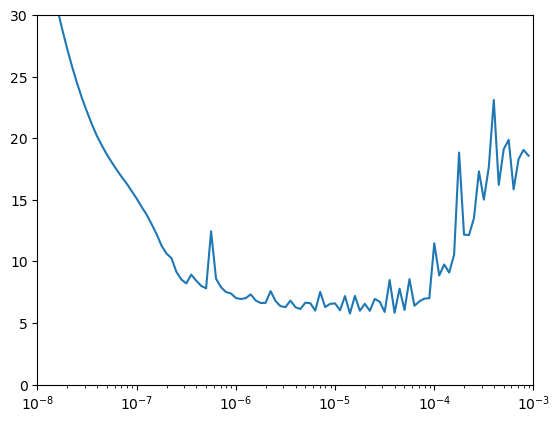

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])

#### model training

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-6,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

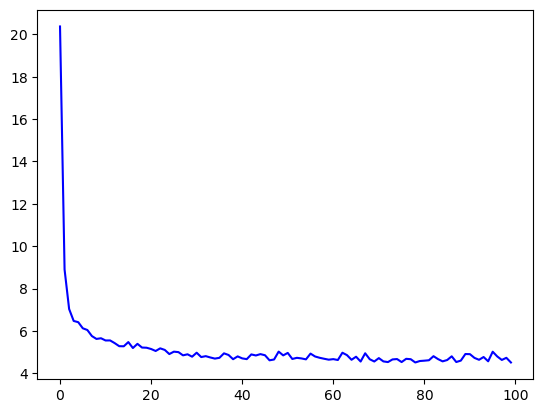

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [21]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [23]:
forecast_series = series[split_time-window:-1]
forecast = model_forecast(model, forecast_series, window, batch)
results = forecast.squeeze()

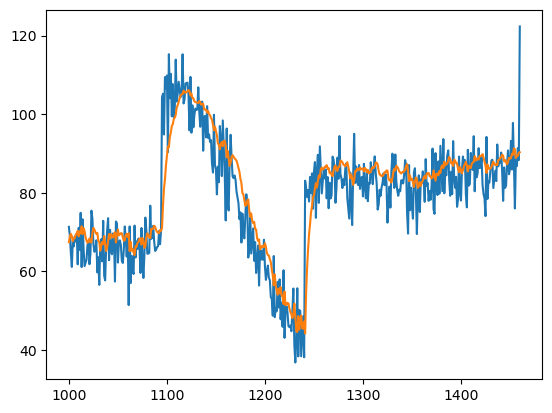

In [24]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [25]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

55.126072
5.580728
